![example](images/pexels-pixabay-40568.png)

# Phase 3 Project

**Author:** Freddy Abrahamson<br>
**Date created:** 3-27-2022<br>
**Discipline:** Data Science

## Overview
For this project, I will be comparing different models:

* Knn
* Decision Trees
* Random Forest
* XGBoost

I will run these models with different hyperparameters, to see which one can best predict if a person will, or will not take the h1n1 flu vaccine. I will use the F1 score as my metric.

## Business Problem

As a consequence of the Covid 19 pandemic, there is a renewed interest in the vaccination rates for the seasonal flu. A governmental agency is performing an exploratory analysis to identify who is more lilely to take the seasonal flu vaccine.

## Data Understanding

The data comes from the National 2009 H1N1 Flu Survey ('H1N1_Flu_Vaccines.csv'). The data is comprised of 36 columns, including the target variable, and 26,707 rows. Each row represents a respondent in the survey. The target variable, 'h1n1_vaccine', is a binary variable which represents whether the respondent took the vaccine or not.

The survey is primarily comprised of binary and multiple choice questions such as:

* 'h1n1_knowledge':&emsp; 0 = No knowledge&emsp;1 = A little knowledge&emsp; 2 = A lot of knowledge
 
*  'health_worker'(binary):&emsp; 0 = no&emsp; 1 = yes


For complete information on the dataset:
https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/

### Import Modules|

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (confusion_matrix, roc_curve, auc, roc_auc_score,f1_score,
                             classification_report, plot_confusion_matrix, precision_recall_curve)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Define Functions

<b>best_model()</b>

The best_model function returns the best train test score combination based on the auc function, where
the difference between the test and the train scores represents the x axis, and test score represents
the y axis. In order use the auc function, for each x,y coordinate we created a list of length three,
with 0 and 1 at the ends, and the actual x,y values in the middle.

The function takes as arguments(data derived from 'cv_results_' form gridsearch):
1. The type of model used. Will be returned as a string.
2. df1: The dataframe where the 'mean test scores' column, and the column containing the 
   difference between the train and test scores are located.
3. df2: The dataframe with the column containing the model parameters(possibly the same). 

The function returns the following:
1. model type: returned as a string
2. best test score: the test score that corresponds to the best auc score
3. best score difference: the difference between the train and test scores
   that corresponds to the best auc score
4. best train-test combination score(auc): the greatest auc score using the 
   'score difference' as the x values, and the 'test score' as the y values
5. best parameters: the model parameters that correspond to the best auc score
6. best dataframe row: the dataframe row in which the best auc score is found


In [2]:
def best_model(model_type, df1, df2):
    from sklearn.metrics import auc
    

#   creating 'test_scores' and 'score_diffs' zero populated lists of shape(rows,3) 
    rows = len(df1)
    test_scores = np.zeros((rows, 3))
    score_diffs = np.zeros((rows, 3))
    auc_scores = []

#   populating 'test_scores' and 'score_diffs' so each list has a format [0,test_score,1],
#   and [0,score_diff,1] respectively
    for row in range(rows):
        test_scores[row][1] = df1['mean_test_score'][row]
        test_scores[row][2] = 1
        score_diffs[row][1] = df1['score_dif'][row]
        score_diffs[row][2] = 1

#   creating a list of all the auc scores
    for row in range(rows):
        auc_score = auc(score_diffs[row], test_scores[row])
        auc_scores.append(auc_score)
        
#   getting the greatest auc score, and the index number of that row    
    best_auc_score = max(auc_scores)
    best_score_index = auc_scores.index(best_auc_score)
    

#   specifying what will be returned
    return (str(model_type), df1['mean_test_score'][best_score_index], df1['score_dif'][best_score_index],
            best_auc_score,df2['params'][best_score_index],best_score_index)


<b>create_model_scores_df()</b>


The function takes as arguments:
1. A GridSearchCV object.
 
The function returns the following:
1. A dataframe created from 'gridsearch_object'.cv_results_
2. A dataframe with all the mean test and mean train scores, as well as the difference between the respective scores.

In [3]:
def create_model_scores_df(gs_obj):
    
    # Creates a dataframe from gs_obj.cv_results_ dictionary:
    results_df = pd.DataFrame(gs_obj.cv_results_)

    # adding new column:
    results_df['score_dif'] = abs(results_df['mean_train_score'] - results_df['mean_test_score'])

    # creates new dataframe with only 'train','test' scores, and their difference:
    score_df = pd.DataFrame()
    score_df = results_df.loc[:,['mean_train_score','mean_test_score','score_dif']]
    
    # returns .cv_results df, and df with mean train/test scores and their difference:
    return results_df, score_df

<b>print_scores()</b>


The function takes as arguments:
1. A GridSearchCV object.
 
The function returns the following:
1. Prints the mean of the 'mean_train_score' column that is returned by 'GridSearchCV'.cv_results_ . 
2. Prints the mean of the 'mean_test_score' column that is returned by 'GridSearchCV'.cv_results_ . 

In [4]:
def print_scores(gs_obj):
    
    # Mean training score
    gs_training_score = np.mean(gs_obj.cv_results_['mean_train_score'])
    
    # Mean test score
    gs_testing_score = np.mean(gs_obj.cv_results_['mean_test_score'])
    
    print(f"Mean Training Score: {gs_training_score :.2%}")
    print(f"Mean Test Score: {gs_testing_score :.2%}")

### Importing Dataset

In [5]:
#importing dataset
df = pd.read_csv('H1N1_Flu_Vaccines.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [8]:
print("Raw Counts")
print(df["h1n1_vaccine"].value_counts())
print()
print("Percentages")
print(df["h1n1_vaccine"].value_counts(normalize=True))

Raw Counts
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

Percentages
0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64


A naive model which simply chooses the majority class, would have an accuracy of over 78%.<br>
Since I am using the F1 score as a metric, the naive strategy would be to predict the minority class<br>
in all cases. In this case the recall =1, precision = .21, and the F1 score = .35.<br>
https://machinelearningmastery.com/naive-classifiers-imbalanced-classification-metrics/

# Preprocessing the Data:

### Dropping Features, Train-test-split, and Dealing with Missing Values: 

In [9]:
#I will drop:
# 'respondent_id' - since it is a unique identifier
# 'employment_industry','employment_occupation','health_insurance' - about 50% or more records missing 
df_II = df.drop(['respondent_id','employment_industry','employment_occupation','health_insurance'], axis=1)

In [10]:
# Split df into X and y
X = df_II.drop("h1n1_vaccine", axis=1)
y = df_II["h1n1_vaccine"]

# Perform train-test split with random_state=42 and stratify=y
# stratify y to maintain uniform ratios of dependent variable y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [11]:
#impute values based on most common value in each column:
X_train = X_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
X_test = X_test.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 11075 to 5212
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 20030 non-null  float64
 1   h1n1_knowledge               20030 non-null  float64
 2   behavioral_antiviral_meds    20030 non-null  float64
 3   behavioral_avoidance         20030 non-null  float64
 4   behavioral_face_mask         20030 non-null  float64
 5   behavioral_wash_hands        20030 non-null  float64
 6   behavioral_large_gatherings  20030 non-null  float64
 7   behavioral_outside_home      20030 non-null  float64
 8   behavioral_touch_face        20030 non-null  float64
 9   doctor_recc_h1n1             20030 non-null  float64
 10  doctor_recc_seasonal         20030 non-null  float64
 11  chronic_med_condition        20030 non-null  float64
 12  child_under_6_months         20030 non-null  float64
 13  health_worker

<b>There is now, no missing data in the training, and test datasets.</b>

### Pre-processing training data:

In [14]:
# splitting dataframe between ordinals , categoricals, and nominals
X_train_ord =  X_train.iloc[:,np.r_[0:2,14:22,24]]
X_train_nom = X_train.iloc[:,30:32]
ord_cols = X_train_ord.columns
nom_cols = X_train_nom.columns
cols_to_drop = ord_cols.append(nom_cols)
X_train_cat = X_train.drop(cols_to_drop, axis=1)
X_train_ord_index = X_train_ord.index
X_train_cat_index = X_train_cat.index

# I will convert all the columns in the dataset to string type, so I can then encode them:
X_train_ord = X_train_ord.astype(str)
X_train_cat = X_train_cat.astype(str)

# creating a Encoder objects:
enc = OrdinalEncoder()
ohe = OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False)

# fitting dataset to OneHotEncoder object:
X_train_enc = enc.fit_transform(X_train_ord)
X_train_ohe = ohe.fit_transform(X_train_cat)

# creating an array with enc and ohe column names:
enc_col_names = X_train_ord.columns
ohe_col_names = ohe.get_feature_names(X_train_cat.columns)

# Setting arrays back to dataframes
X_train_enc_df = pd.DataFrame(X_train_enc, columns=enc_col_names,index=X_train_ord_index)
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_col_names,index=X_train_cat_index)

# putting the datframe back together:
X_train_II_encoded = pd.concat([X_train_enc_df,X_train_ohe_df,X_train_nom],axis=1)
X_train_II_encoded.head()

# resampling with Smote *after some trial and error, I found .40 to be optimal:
X_train_II_encoded_resampled, y_train_resampled = SMOTE(sampling_strategy=0.40).fit_resample(X_train_II_encoded, y_train)


In [15]:
# After applying SMOTE the minority class(1), is now 40% of the majority class (0): 
print("Raw Counts")
print(y_train_resampled.value_counts())
print()
print("Percentages")
print(y_train_resampled.value_counts(normalize=True))

Raw Counts
0    15775
1     6310
Name: h1n1_vaccine, dtype: int64

Percentages
0    0.714286
1    0.285714
Name: h1n1_vaccine, dtype: float64


### Pre-processing test data:

In [48]:
# splitting dataframe between ordinals and categoricals
X_test_ord =  X_test.iloc[:,np.r_[0:2,14:22,24]]
X_test_nom = X_test.iloc[:,30:32]
ord_cols = X_test_ord.columns
nom_cols = X_test_nom.columns
cols_to_drop = ord_cols.append(nom_cols)
X_test_cat = X_test.drop(cols_to_drop, axis=1)

# create index arrays to use when I recreate the dataframe
X_test_ord_index = X_test_ord.index
X_test_cat_index = X_test_cat.index

# I will convert all the columns in the dataset to string type, so I can then encode them:
X_test_ord = X_test_ord.astype(str)
X_test_cat = X_test_cat.astype(str)

# Setting arrays back to dataframes
X_test_enc_df = pd.DataFrame(enc.transform(X_test_ord), columns=enc_col_names,index=X_test_ord_index)
X_test_ohe_df = pd.DataFrame(ohe.transform(X_test_cat), columns=ohe_col_names,index=X_test_cat_index)

#putting the datframe back together:
X_test_II_encoded = pd.concat([X_test_enc_df,X_test_ohe_df,X_test_nom],axis=1)
X_test_II_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6677 entries, 12369 to 24368
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   h1n1_concern                          6677 non-null   float64
 1   h1n1_knowledge                        6677 non-null   float64
 2   opinion_h1n1_vacc_effective           6677 non-null   float64
 3   opinion_h1n1_risk                     6677 non-null   float64
 4   opinion_h1n1_sick_from_vacc           6677 non-null   float64
 5   opinion_seas_vacc_effective           6677 non-null   float64
 6   opinion_seas_risk                     6677 non-null   float64
 7   opinion_seas_sick_from_vacc           6677 non-null   float64
 8   age_group                             6677 non-null   float64
 9   education                             6677 non-null   float64
 10  income_poverty                        6677 non-null   float64
 11  behavioral_a

In [49]:
X_test_II_encoded.head()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,...,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,seasonal_vaccine_0,seasonal_vaccine_1,household_adults,household_children
12369,3.0,1.0,3.0,0.0,3.0,3.0,0.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17593,3.0,2.0,4.0,1.0,0.0,4.0,1.0,0.0,1.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2.0
2698,3.0,1.0,3.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0
13754,2.0,2.0,3.0,1.0,1.0,3.0,1.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
7106,2.0,1.0,2.0,3.0,1.0,0.0,3.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0


# Classification models:

## K Nearest Neighbors (KNN)

### K Nearest Neighbors Baseline Model:

In [17]:
# Creating K nearest neighbor classifier object 
knn = KNeighborsClassifier(n_jobs = -1)

# using 2-split cross-validation to score the classification:
knn_cv_score = cross_val_score(knn, X_train_II_encoded_resampled, y_train_resampled, scoring="f1", cv=2)

# return the mean of the 2 f1 scores:
mean_knn_cv_score = np.mean(knn_cv_score)
print(f"Mean Cross Validation Score: {mean_knn_cv_score :.2%}")

Mean Cross Validation Score: 64.65%


### Using GridSearchCV to create additional KNN models:

In [18]:
# Define the parameter grid:

knn_param_grid = {
    'n_neighbors': [5,12,20],
    'metric'     : ['minkowski'],
    'p'          : [1,2,3,4]
    
}

In [19]:
# instantiate GridSearchCV object:
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=2, scoring='f1',return_train_score=True, n_jobs = -1)

# fit to the data:
knn_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [20]:
print_scores(knn_grid_search)

Mean Training Score: 66.37%
Mean Test Score: 60.42%


In [21]:
knn_results_df, knn_score_df =  create_model_scores_df(knn_grid_search)
knn_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,12.000000,12.000000,12.000000
mean,0.663663,0.604197,0.059465
std,0.050103,0.027340,0.025870
min,0.600687,0.567539,0.030059
25%,0.631062,0.583516,0.038890
50%,0.647346,0.596608,0.050332
75%,0.704059,0.625408,0.078651
max,0.755202,0.646542,0.111043


## Decision Trees

### Decision Tree Baseline Model:

In [22]:
# Creating decision tree classifier object
dec_tree = DecisionTreeClassifier(random_state=42)

# using 2-split cross-validation to score the classification:
dec_tree_cv_score = cross_val_score(dec_tree, X_train_II_encoded_resampled, y_train_resampled, cv=2,scoring='f1')

# return the mean of the 2 f1 scores:
mean_dec_tree_cv_score = np.mean(dec_tree_cv_score)
print(f"Mean Cross Validation Score: {mean_dec_tree_cv_score :.2%}")

Mean Cross Validation Score: 60.79%


### Using GridSearchCV to create additional Decision Tree models:

In [23]:
# Define the parameter grid:

dec_tree_param_grid = {
    'criterion'        : ['gini', 'entropy'],
    'max_depth'        : [None,5,6, 7, 8],
    'min_samples_split': [2,3,5],
    'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
    'class_weight'     : [None, 'balanced']
}

In [24]:
# instantiate GridSearchCV object:
dec_tree_grid_search = GridSearchCV(dec_tree, dec_tree_param_grid, cv=2, return_train_score=True, 
                                    scoring='f1', n_jobs = -1)

# fit to the data:
dec_tree_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [25]:
print_scores(dec_tree_grid_search)

Mean Training Score: 76.08%
Mean Test Score: 65.15%


In [26]:
dec_tree_results_df, dec_tree_score_df =  create_model_scores_df(dec_tree_grid_search)
dec_tree_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,360.000000,360.000000,360.000000
mean,0.760834,0.651462,0.109372
std,0.073325,0.029733,0.094809
min,0.701968,0.584280,0.029462
25%,0.714262,0.629202,0.047320
50%,0.732539,0.650557,0.078091
75%,0.752200,0.681296,0.113855
max,1.000000,0.690299,0.392054


## Random Forests

### Random Forest Baseline Model:

In [27]:
# creating random forest classifier object:
forest = RandomForestClassifier(n_jobs = -1,random_state=42)

# using 2-split cross-validation to score the classification:
forest_cv_score = cross_val_score(forest, X_train_II_encoded_resampled, y_train_resampled, cv=2,scoring='f1')

# return the mean of the 2 f1 scores:
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")

Mean Cross Validation Score: 67.73%


### Using GridSearchCV to create additional Random Forests:

In [28]:
# Define the parameter grid:

forest_param_grid = {
              'criterion'        : ['gini', 'entropy'],
              'max_depth'        : [None, 4,5,6,8],
              'min_samples_split': [2,3,4,6],
              'max_features'     : [15, 20, 28, 32, 'auto'],
             'class_weight'      : [None, 'balanced'],
              'n_estimators'     : [100, 150]
         
}

In [29]:
# Instantiate GridSearchCV object:
forest_grid_search = GridSearchCV(forest, forest_param_grid, cv=2, return_train_score=True,
                                  scoring='f1', n_jobs = -1)

# Fit to the data:
forest_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [30]:
print_scores(forest_grid_search)

Mean Training Score: 78.01%
Mean Test Score: 66.90%


In [31]:
forest_results_df, forest_score_df =  create_model_scores_df(forest_grid_search)
forest_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,800.000000,800.000000,800.000000
mean,0.780074,0.669038,0.111037
std,0.109082,0.031645,0.102096
min,0.628180,0.576898,0.022708
25%,0.711912,0.651688,0.043603
50%,0.735937,0.680077,0.070931
75%,0.783166,0.694086,0.109403
max,1.000000,0.707529,0.337069


## XGBoost

In [32]:
# Creating new dataframes with 2 column names modified so they work with XGBoost(prevent error):

X_train_III_encoded = X_train_II_encoded_resampled.rename(columns={'education_< 12 Years': 'education less than 12 Years', 
                                                         'income_poverty_<= $75,000, Above Poverty':
                                                         'income_poverty less than or = to $75000_Above Poverty'})
X_test_III_encoded = X_test_II_encoded.rename(columns={'education_< 12 Years': 'education less than 12 Years', 
                                                         'income_poverty_<= $75,000, Above Poverty':
                                                         'income_poverty less than or = to $75000_Above Poverty'})

### XGBoost Baseline Model:

In [33]:
# Creating XGBoost classifier object:
xgboost_clf = XGBClassifier(random_state=42, n_jobs = -1)

# using 2-split cross-validation to score the classification:
xgboost_clf_cv_score = cross_val_score(xgboost_clf, X_train_II_encoded_resampled, y_train_resampled,
                                       cv=2, scoring='f1')

# return the mean of the 2 f1 scores:
mean_xgboost_clf_cv_score = np.mean(xgboost_clf_cv_score)
print(f"Mean Cross Validation Score: {mean_xgboost_clf_cv_score :.2%}")

Mean Cross Validation Score: 61.96%


### Using GridSearchCV to create additional XGBoost Classifiers:

In [34]:
# Define the parameter grid:

xgboost_param_grid = {
    'learning_rate': [None, .08, .1],
    'max_depth': [None, 4, 5, 6 ],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.65, 1],
    'min_split_loss' : [0, .5],
    'n_estimators' : [100, 160],
    'reg_alpha':[None, .5,],
    'scale_pos_weight' : [None, 3.0]
    
}

In [35]:
# Instantiate GridSearchCV object:
xgboost_clf_grid_search = GridSearchCV(xgboost_clf, xgboost_param_grid, cv=2, return_train_score=True,
                                  scoring='f1', n_jobs = -1)

# Fit to the data
xgboost_clf_grid_search.fit(X_train_II_encoded_resampled, y_train_resampled);

In [36]:
print_scores(xgboost_clf_grid_search)

Mean Training Score: 85.49%
Mean Test Score: 65.44%


In [37]:
xgboost_results_df, xgboost_score_df =  create_model_scores_df(xgboost_clf_grid_search)
xgboost_score_df.describe()

,mean_train_score,mean_test_score,score_dif
count,1152.000000,1152.000000,1152.000000
mean,0.854860,0.654419,0.200441
std,0.055576,0.034454,0.068268
min,0.771661,0.605109,0.075093
25%,0.814198,0.622338,0.149143
50%,0.841629,0.640784,0.194633
75%,0.884310,0.694344,0.250777
max,0.980350,0.702982,0.353929


# Choosing the Best Model:

In [38]:
#Creating a dataframe to compare models

#creating list of arguments for the 'best_model' function
best_model_args = [['knn', knn_score_df, knn_results_df],
                   ['decsion tree', dec_tree_score_df, dec_tree_results_df],
                   ['random forest', forest_score_df, forest_results_df],
                   ['xgboost', xgboost_score_df, xgboost_results_df]]


# loop counter representing the 4 sets of arguments for the 'best_model' function
counter = 0
# this list will hold the stats for each model
model_stats_list = []
# column names used to create the dataframe
model_stats_df_cols = ['model type','best test score(f1)','best score difference',
                      'best train-test combination score(auc)','best parameters',
                      'best dataframe row']

# loop used to populate 'model_stats_list'
while counter <4:
    args = best_model_args[counter]
    model_stats = best_model(args[0],args[1],args[2])
    model_stats_list.append(model_stats)
    counter+=1

# creating dataframe from the 'model_stats_list'
model_stats_df = pd.DataFrame(model_stats_list, columns=model_stats_df_cols)
pd.set_option('display.max_colwidth', None)
model_stats_df   

,model type,best test score(f1),best score difference,best train-test combination score(auc),best parameters,best dataframe row
0,knn,0.613334,0.039954,0.786690,"{'metric': 'minkowski', 'n_neighbors': 12, 'p': 2}",5
1,decsion tree,0.684905,0.029462,0.827722,"{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}",198
2,random forest,0.699000,0.030049,0.834476,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 20, 'min_samples_split': 4, 'n_estimators': 150}",693
3,xgboost,0.699029,0.076051,0.811489,"{'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 3, 'min_split_loss': 0, 'n_estimators': 100, 'reg_alpha': None, 'scale_pos_weight': 3.0, 'subsample': 0.65}",546


The best model, based on the auc metric (0.831498) is random Forest, with an F1 test score of 0.694205.	

# Recreating the  the Best Model:

In [39]:
# Instantiate a RandomForestClassifier object:
best_forest = RandomForestClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 5,
                                      max_features = 32, min_samples_split = 2, n_estimators = 150,
                                      random_state = 42, n_jobs = -1)

# Fit data to the RandomForestClassifier object:
best_forest.fit(X_train_II_encoded_resampled, y_train_resampled)
best_forest_preds = best_forest.predict(X_test_II_encoded)

#Returns the f1 score on the given test data and labels:
score = f1_score(y_test, best_forest_preds)
score

0.6298719772403982

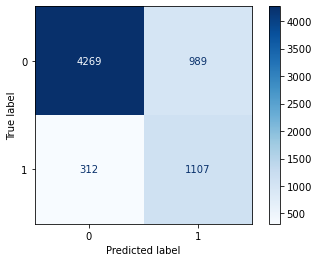

In [40]:
# Visualize your confusion matrix
plot_confusion_matrix(best_forest, X_test_II_encoded, y_test,
                     cmap=plt.cm.Blues)
plt.show()

## Finding best threshold to optimize F1 score:

In [41]:
yhat = best_forest.predict_proba(X_test_II_encoded)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# function returns three np. arrays: precison, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, yhat)

In [42]:
#creating 'prc_arr' 2d array, by appending precison', 'recall', 'thresholds':
n = 0
prc_arr = []
while n < len (thresholds):
    prc_return = []
    prc_return.append(precision[n])
    prc_return.append(recall[n])
    prc_return.append(thresholds[n])
    prc_arr.append(prc_return)
    n+=1

In [43]:
# creating column names list:
f_score_df_col_names = ['precision', 'recall', 'thresholds']

# converting 'prc_arr' to a dataframe:
f_scores_df = pd.DataFrame(prc_arr, columns=f_score_df_col_names)

# creating a new column that calculates the f-score:
f_scores_df['f_score'] = ((2 * f_scores_df['precision'] * f_scores_df['recall']) /
                         (f_scores_df['precision'] + f_scores_df['recall']))

# sort descending by f_score:
f_scores_df = f_scores_df.sort_values(by='f_score', ascending=False)
f_scores_df

,precision,recall,thresholds,f_score
4554,0.607650,0.694151,0.585937,0.648026
4513,0.599042,0.705426,0.576494,0.647896
4553,0.607275,0.694151,0.585868,0.647813
4500,0.595858,0.709655,0.574884,0.647797
4559,0.608292,0.692741,0.587373,0.647776
...,...,...,...,...
5855,1.000000,0.002114,0.941095,0.004219
5854,0.750000,0.002114,0.941033,0.004216
5853,0.600000,0.002114,0.940688,0.004213
5856,1.000000,0.001409,0.941282,0.002815


<b>Based on an optimal threshold of 0.571795 our final f1 score is 0.646012<b>

## Obtain most important features

In [47]:
# creating a 'ftr_importance' array:
ftr_importance = np.array(best_forest.feature_importances_)

# creating a 'ftr_names' array:
ftr_names = np.array(X_train_II_encoded.columns)

# putting the two arrays together to create a 2d dataframe:
ftr_importance_arr = np.vstack((ftr_names, ftr_importance)).T

# creating column names list for dataframe:
col_names = ['ftr_name', 'ftr_importance']

# converting 'ftr_importance_arr' into a dataframe and sorting by feature importance:
ftr_importance_df = pd.DataFrame(ftr_importance_arr, columns=col_names).sort_values(
    by='ftr_importance')

pd.set_option('display.max_rows', None)
ftr_importance_df

,ftr_name,ftr_importance
56,hhs_geo_region_oxchjgsf,4.99558e-06
50,hhs_geo_region_dqpwygqj,2.4478e-05
53,hhs_geo_region_lrircsnp,2.56834e-05
48,hhs_geo_region_atmpeygn,3.03929e-05
14,behavioral_avoidance_1.0,3.92847e-05
29,chronic_med_condition_0.0,4.36033e-05
40,sex_Male,4.63349e-05
24,behavioral_touch_face_1.0,4.84274e-05
13,behavioral_avoidance_0.0,5.39309e-05
23,behavioral_touch_face_0.0,5.797e-05


In [45]:
# create an abridged dataframe that contributes at least 0.0001 towards 'gini' reduction:
ftr_importance_df_II = ftr_importance_df.loc[ftr_importance_df['ftr_importance']>=0.0005]
ftr_importance_df_II = ftr_importance_df_II.reset_index(drop=True)
ftr_importance_df_II['ftr_importance'].sum()

0.9943381813686875

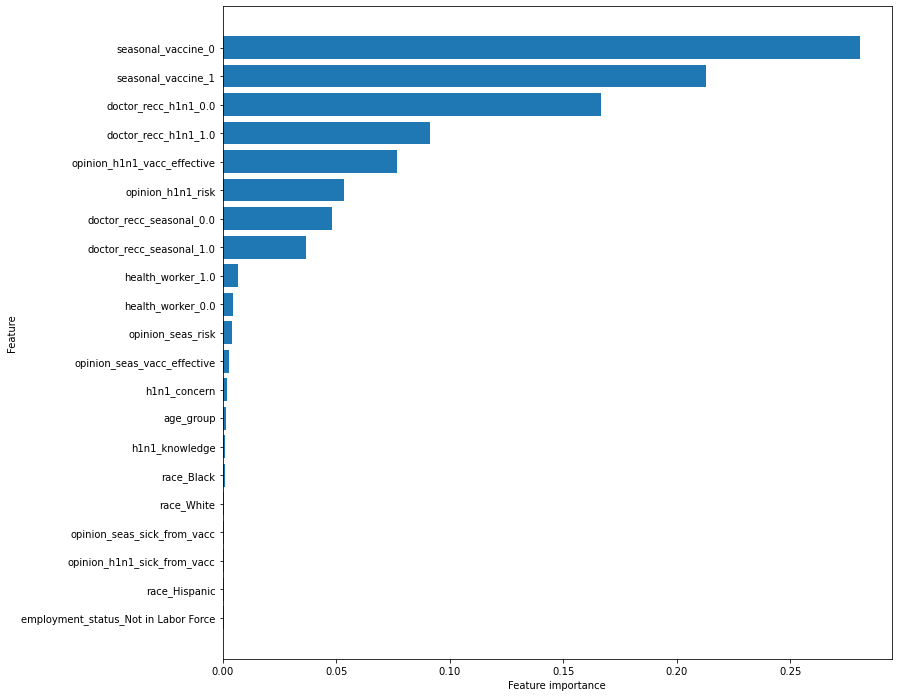

In [46]:
def plot_feature_importances(model):
    n_features = model.shape[0]
    plt.figure(figsize=(12,12))
    plt.barh(range(n_features), model['ftr_importance'], align='center') 
    plt.yticks(np.arange(n_features), model['ftr_name']) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(ftr_importance_df_II)

# Recommendations

<b>metric</b>: F1 score

<b>model</b>: Random Forest

<b>model parameters</b>: class_weight = 'balanced', criterion = 'gini', max_depth = 5,<br>
                         max_features = 32, min_samples_split = 2, n_estimators = 150,<br>
                         random_state = 42, n_jobs = -1<br>
                              
<b>how to handle class imbalance</b> &emsp;: SMOTE(sampling_strategy=0.40) 

<b>Recommend to place a special emphasis on the following features, since they account for more
than 99% of total feature importance metric (decrease in the gini impurity score):</b>
* race_White
* opinion_h1n1_sick_from_vacc
* employment_status_Employed
* opinion_seas_sick_from_vacc
* h1n1_knowledge
* age_group
* race_Black
* h1n1_concern
* opinion_seas_vacc_effective
* opinion_seas_risk
* health_worker_0.0
* health_worker_1.0
* doctor_recc_seasonal_1.0
* opinion_h1n1_risk
* doctor_recc_seasonal_0.0
* opinion_h1n1_vacc_effective
* doctor_recc_h1n1_1.0
* doctor_recc_h1n1_0.0
* seasonal_vaccine_1
* seasonal_vaccine_0


# Project Conclusion: Main Take-aways

1. This project helped me appreciate that there a few things that should be done prior to working with the models:
       1. Clearly define a question, or goal that would be resolved by the model.
       2. Choose a metric that would best measure the success of your model,as it pertains to your goal.
       3. Try to define a naive strategy, and its success rate, so you have something to compare your model to.


2. My goal in this project was to create a model that would identify, as correctly as possible, who will, and who won't take the h1n1 vaccine. My prediction results could be categorized as any of the following four:    
       1. True positive: The respondent was predicted to have taken the vaccine, and actually took it.
       2. True negative: The respondent was predicted not to have taken the vaccine, and did not take it.
       3. False positive: The respondent was predicted to have taken the vaccine, but did not take it.
       4. False negative: The respondent was predicted to not have taken the vaccine, but actually took it.

Given that my goal is to be as 'accurate' as possible, there is no upside in identifying one class more aggresively than the other. I chose the F1 metric because it does a good job of minimizing false positives, and false negatives on an imbalanced data set. 

3. I used the auc function to determine the best train/test score combination. I set the difference between the train and the test scores as the x axis, and the test score itself as the y axis. Based on this the Random Forest model was the best.

4. I found the optimal threshold using the precision recall curve to obtain the best possible F1 score for that model.

5. I thought of using a voting classifier, but I decided against it because I saw there may have been some complications defining the feature recomendations, specially if I included knn which doesn't have an easy way to identify feature importance.

6. I also thought of starting off by finding the optimal threshold, and then try to derive the best model, using that threshold. I decided against it because I was taking lomger on the project than I had planned, and I would have to manually code the class selection based on the new threshold, and score it based on that. 
  